### Script to generate FATES parameters using LHS

In [1]:
from scipy.stats import qmc
import numpy as np
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re
import modp as mp
from matplotlib import pyplot as plt
from scipy.io import netcdf as nc
import importlib
import math

In [2]:
pd.set_option('display.max_rows', 500) 

### Read in min and max values for each parameter and pft 
- Adapted from work by Rachel Ward (parameter ranges and inequalities). 
- Where there are inequalities between PFTx and PFTy, sample PFTx parameter and then use a scalar to generate PFTy parameter. -- If parameter ranges are the same ignore the inequality
- Add some noise to the inequalities so that inter-PFT trait correlations are not too strict

## User-defined params

In [12]:
#path_to_ca_fates = '/home/adam/cloud/gdrive/postdoc/california-fates'

#path_to_base_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters/'
path_to_base_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25'
#path_to_ensemble_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters/ensemble_params_test'
path_to_ensemble_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/'

path_to_ca_fates = '/glade/u/home/adamhb/california-fates'

# The parameter file used for parameter values that don't vary in the ensemble 
base_param_file_name = 'ca_ahb_5pfts_092123.nc'

# New param file name prefix for the parameter files that do vary
file_name_prefix = 'ca_5pfts_100523'

# Number of instances
n_inst = 4320

# Instances per case
inst_per_case = 216

n_cases = 20

# Path to parameter ranges
param_ranges_full = pd.read_csv(os.path.join(path_to_ca_fates,'parameter_ranges/param_range_archive/param_ranges_100223.csv'))

# Prefix for subdirectories where param files for the ensemble are kept
param_files_subdir_prefix = 'ca_5pfts_20cases_4320inst_101223'

## Param file subdirs

In [13]:
param_file_subdirs = []
for subdir_i in range(n_cases):
    subdir_tag = str(subdir_i+1).rjust(2, '0')
    param_file_subdirs.append(param_files_subdir_prefix +"_" + subdir_tag)
print(param_file_subdirs)

['ca_5pfts_20cases_4320inst_101223_01', 'ca_5pfts_20cases_4320inst_101223_02', 'ca_5pfts_20cases_4320inst_101223_03', 'ca_5pfts_20cases_4320inst_101223_04', 'ca_5pfts_20cases_4320inst_101223_05', 'ca_5pfts_20cases_4320inst_101223_06', 'ca_5pfts_20cases_4320inst_101223_07', 'ca_5pfts_20cases_4320inst_101223_08', 'ca_5pfts_20cases_4320inst_101223_09', 'ca_5pfts_20cases_4320inst_101223_10', 'ca_5pfts_20cases_4320inst_101223_11', 'ca_5pfts_20cases_4320inst_101223_12', 'ca_5pfts_20cases_4320inst_101223_13', 'ca_5pfts_20cases_4320inst_101223_14', 'ca_5pfts_20cases_4320inst_101223_15', 'ca_5pfts_20cases_4320inst_101223_16', 'ca_5pfts_20cases_4320inst_101223_17', 'ca_5pfts_20cases_4320inst_101223_18', 'ca_5pfts_20cases_4320inst_101223_19', 'ca_5pfts_20cases_4320inst_101223_20']


In [14]:
for i in range(len(param_file_subdirs)):
    os.makedirs(os.path.join(path_to_ensemble_param_files_root,param_file_subdirs[i]),exist_ok=True)

### Pre-process param ranges file

In [15]:


pft_names = ['pine','cedar','fir','shrub','oak']

param_ranges_full = param_ranges_full[['pft_ineq','param', 'value_min', 'value_max', 'pft', 'organ']]

# Filter to params that we are going to sample from the LHS
param_ranges = param_ranges_full.loc[param_ranges_full['pft_ineq'] == 'FALSE']

# Make sure min and max are floats
convert_dict = {'value_min': float,
                'value_max': float
                }
param_ranges = param_ranges.astype(convert_dict)

# number of parameters
n_params = len(param_ranges)
print("Number of params:",n_params)

# number of PFTs - some are global so subtract one
n_pfts = max(len(pd.unique(param_ranges['pft'])) - 1, 1)
print("Number of pfts:", n_pfts)

param_names = list(param_ranges.param)
print("Param names:",param_names)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

param_ranges.info()

Number of params: 63
Number of pfts: 5
Param names: ['fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_alloc_mature', 'fates_recruit_seed_dbh_repro_threshold', 'fates_recruit_seed_dbh_repro_threshold', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_alpha_SH', 'fates_fire_bark_scaler', 'fates_fire_bark_scaler', 'fates_fire_bark_scaler', 'fates_fire_crown_kill', 'fates_fire_crown_kill', 'fates_fire_crown_kill', 'fates_fire_drying_ratio', 'fates_fire_nignitions', 'fates_fire_threshold', 'fates_mort_bmort', 'fates_mort_bmort', 'fates_mort_bmort', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_slatop', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_leaf_vcmax25top', 'fates_mort_scalar_cstarvation', 'fates_mort_scalar_cstarvation', 'fates_mort_scalar_cstarvation', 'fates_fire_frac_resprout', 'fates_fire_frac_resprout', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_frag_seed_decay_rate', 'fates_recruit_se

In [16]:
param_ranges_inequalities = param_ranges_full.loc[param_ranges_full['pft_ineq'] != 'FALSE']

In [17]:
param_ranges_inequalities

,pft_ineq,param,value_min,value_max,pft,organ
1,<pine,fates_recruit_seed_alloc_mature,0.040000,0.392860,2,NaN
2,<pine,fates_recruit_seed_alloc_mature,0.040000,0.392860,3,NaN
6,pine,fates_recruit_seed_dbh_repro_threshold,10.000000,30.000000,2,NaN
7,pine,fates_recruit_seed_dbh_repro_threshold,10.000000,30.000000,3,NaN
10,>pine,fates_fire_alpha_SH,0.100000,0.900000,2,NaN
11,>pine,fates_fire_alpha_SH,0.100000,0.900000,3,NaN
15,<pine,fates_fire_bark_scaler,0.020000,0.080000,2,NaN
16,<cedar,fates_fire_bark_scaler,0.020000,0.080000,3,NaN
20,>pine,fates_fire_crown_kill,0.200000,1.000000,2,NaN
21,>pine,fates_fire_crown_kill,0.200000,1.000000,3,NaN


### Sample the parameter space using a Latin Hypercube approach

In [18]:
sampler = qmc.LatinHypercube(d=n_params, seed=31)
sample = sampler.random(n=n_inst)

# scale to parameter ranges
l_bounds = param_ranges['value_min']
u_bounds = param_ranges['value_max']

scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

print("ensemble dimensions:",scaled_sample.shape)

#Create a dataframe of the LHS ensemble
col_names = [v + "_" + str(p) for v,p in zip(param_names,pfts)]
lhs_df = pd.DataFrame(data=scaled_sample,columns=col_names)

ensemble dimensions: (4320, 63)


### Visualize distribution of parameter ranges sampled by the LHS

In [19]:
# lhs_df['fates_turnover_branch_1'].hist(bins=10, figsize=(20,15))
# plt.show()

### Construct parameter files from the LHS samples

In [20]:
## Read in FATES file with values that will be used for all non-varying parameters

# This parameter file has many changes associated with it compared to the default FATES file
# It also has new parameter added as part of the development required for this experiment.
input_fname = os.path.join(path_to_base_param_files_root,base_param_file_name)

print(input_fname)

# for each sample
row = -1

for subdir in param_file_subdirs:
    
    for i in range(0,inst_per_case) :
        
        row = row + 1
        print("row",row)
        
        param_file_end = str(i+1).rjust(4, '0')

        print(param_file_end)

        # final parameter file name
        new_file_name = file_name_prefix + '_{0}.nc'.format(param_file_end)
        fout = os.path.join(path_to_ensemble_param_files_root,subdir,new_file_name)

        shutil.copyfile(input_fname, fout)                                                                                                                             
      
        # loop through each parameter and apply either to the correct pft or globally
        for j in range(0, n_params) : 
           
            var = param_names[j]
            pft = pfts[j]
            organ = organs[j]
            val = scaled_sample[row, j]
            
            mp.main(var = var, pft = pft, fin = fout, val = val, 
                        fout = fout, O = 1, organ = organ)

/glade/u/home/adamhb/ahb_params/fates_api_25/ca_ahb_5pfts_092123.nc
row 0
0001
row 1
0002
row 2
0003
row 3
0004
row 4
0005
row 5
0006
row 6
0007
row 7
0008
row 8
0009
row 9
0010
row 10
0011
row 11
0012
row 12
0013
row 13
0014
row 14
0015
row 15
0016
row 16
0017
row 17
0018
row 18
0019
row 19
0020
row 20
0021
row 21
0022
row 22
0023
row 23
0024
row 24
0025
row 25
0026
row 26
0027
row 27
0028
row 28
0029
row 29
0030
row 30
0031
row 31
0032
row 32
0033
row 33
0034
row 34
0035
row 35
0036
row 36
0037
row 37
0038
row 38
0039
row 39
0040
row 40
0041
row 41
0042
row 42
0043
row 43
0044
row 44
0045
row 45
0046
row 46
0047
row 47
0048
row 48
0049
row 49
0050
row 50
0051
row 51
0052
row 52
0053
row 53
0054
row 54
0055
row 55
0056
row 56
0057
row 57
0058
row 58
0059
row 59
0060
row 60
0061
row 61
0062
row 62
0063
row 63
0064
row 64
0065
row 65
0066
row 66
0067
row 67
0068
row 68
0069
row 69
0070
row 70
0071
row 71
0072
row 72
0073
row 73
0074
row 74
0075
row 75
0076
row 76
0077
row 77
0078
row 78

### Add values that require a pft-inequality

In [21]:
def contains_angle_brackets(s):
    return '<' in s or '>' in s

In [22]:
def get_param_value_from_ineq(ref_pft_value,min_val,max_val,pft_ineq):
    '''returns the parameter value for the pft that depends on a reference pft value'''
    
    if contains_angle_brackets(pft_ineq):
        if ">" in pft_ineq:
            min_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
        if "<" in pft_ineq:
            max_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
    else:
        new_value = ref_pft_value
    
    return new_value

def get_ref_pft_index(ineq):  
    for p in pft_names:
        if p in ineq:
            return pft_names.index(p)

def find_files_with_substring(directory, substring):
    """
    Returns a list of filenames in the given directory that contain the given substring.
    
    :param directory: The path to the directory to search in.
    :param substring: The substring to search for in filenames.
    :return: A list of filenames containing the substring.
    """

    # List all files in the directory
    all_files = os.listdir(directory)

    # Filter the ones that contain the substring
    matching_files = [f for f in all_files if substring in f]

    return matching_files


def extract_variable_from_netcdf(file_path, variable_name,pft_index,organ_index):
    """
    Extract a variable from a NetCDF file.

    Parameters:
    - file_path: The path to the NetCDF file.
    - variable_name: The name of the variable to extract.
    - pft index (python index starting at 0)
    - organ index (python index starting at 0)

    Returns:
    - The extracted variable data.
    """
    with nc4.Dataset(file_path, 'r') as dataset:
        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            variable_data = dataset.variables[variable_name][:]
            if organ_index == None:
                if len(variable_data.shape) > 1:
                    return variable_data[0,pft_index]
                else:
                    return variable_data[pft_index]
            else:
                return variable_data[organ_index,pft_index]
        else:
            raise ValueError(f"'{variable_name}' not found in the NetCDF file.")

def assign_var_to_nc(file,var,value,pft,organ):
    
    '''
    assigns a value to a netcdf for a particular pft and organ
    
    file = full path to netcdf
    var = fates parameter name
    value = parameter value to add to file
    pft = pft number starting at 1
    organ = organ id starting at 1
    '''
    
    # open nc file
    ncfile = nc.netcdf_file(file, 'a')
    
    # define param of interest
    var = ncfile.variables[var]
    
    # get number of dimensions
    ndim = len(var.dimensions)
    
    if var.dimensions[0] == 'fates_leafage_class':
        #print("using vcmax")
        var[:,int(pft-1)] = value
    
    
    else:
        
        # if ndim > 1 then we have pft and organ
        if ndim > 1:
            #print("using A")
            var[int(organ-1),int(pft-1)] = value

        # if pft = 0 (global), and we specify an organ 
        if (pft == 0) & (not np.isnan(organ)):
            var[(int(organ - 1))] = value
            #print("using B")
        
        # if pft = 0 and organ is NA
        if (pft == 0) & (np.isnan(organ)):
            var[:] = value
            #print("using new one")
        
        # if pft is specified, but organ is not
        if (pft > 0) & (ndim == 1):
            var[(int(pft - 1))] = value
            #print("using C")

### Test

In [23]:
# ref_nc_file = find_files_with_substring(os.path.join(path_to_ensemble_param_files_root,param_files_subdir), "0002")
# print(ref_nc_file[0])
# ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,param_files_subdir,ref_nc_file[0])
# print(ref_nc_file_full_path)

# a = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
#                              variable_name='fates_frag_maxdecomp',
#                              pft_index=0,organ_index=None)

# a

# with nc4.Dataset(ref_nc_file_full_path, 'r') as dataset:
#     variable_data = dataset.variables["fates_leaf_vcmax25top"][:]
#     print(variable_data[0,0])

In [24]:
#param_ranges_inequalities.info()

In [25]:
#Loop through ensemble members
for subdir in param_file_subdirs:
    
    for inst in range(0,inst_per_case) :

        # Get tag
        param_file_end = str(inst+1).rjust(4, '0')

        # Get param file with inst tag
        ref_nc_file = find_files_with_substring(directory=os.path.join(path_to_ensemble_param_files_root,
                                                                       subdir),
                                                substring=param_file_end)

        # Get full path of ref param file
        ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,subdir,ref_nc_file[0])

        print(ref_nc_file_full_path)

        #Loop through parameters
        for i in param_ranges_inequalities.index:

            # input data from the inequalities df
            d = param_ranges_inequalities.loc[i]
            ref_pft_index = get_ref_pft_index(d['pft_ineq'])

            #print(d['param'])

            #print(ref_pft_index)

            #case where we want one parameter to be the same as another
            if "fates" in d['pft_ineq']:

                #print('Case of fates param same as another')

                output_val = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
                                                          variable_name=d['pft_ineq'],
                                                          pft_index=None, organ_index=None)
                assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,
                                 d['pft'],d['organ'])
            #case where we are directly calculating the value
            elif "FIXED" in d['pft_ineq']:

                #print('Case FIXED')

                # Calculate parameter value
                # In this case the reference parameter is always
                output_val = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
                                                          variable_name=d['param'],pft_index=0,
                                                          organ_index=None)
                output_val = output_val * d['value_max']

                assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,d['pft'],d['organ'])

            #case where we want an inequality between the pfts
            else:

                #print('Case inequality')

                if math.isnan(d['organ']):
                    organ_index = None
                else:
                    organ_index = int(d['organ']-1)

                ref_pft_value = extract_variable_from_netcdf(ref_nc_file_full_path, d['param'],
                                                             pft_index=ref_pft_index, organ_index=organ_index)

                #print(ref_pft_value)
                #print(d['param'])

                output_val = get_param_value_from_ineq(ref_pft_value,min_val = d['value_min'],
                                                       max_val = d['value_max'],pft_ineq = d['pft_ineq'])

                assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,d['pft'],d['organ'])
                #print("\n")

/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0001.nc


/glade/scratch/adamhb/ipykernel_19365/3274503201.py:79: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  ncfile = nc.netcdf_file(file, 'a')


/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0002.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0003.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0004.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0005.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0006.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0007.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0008.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst_101223_01/ca_5pfts_100523_0009.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_5pfts_20cases_4320inst

## Check the distribution of a variable in the parameter files

In [27]:
shrub_vcmaxrange = []

#Loop through ensemble members
for subdir in param_file_subdirs:
    
    for inst in range(0,inst_per_case) :

        # Get tag
        param_file_end = str(inst+1).rjust(4, '0')

        # Get param file with inst tag
        ref_nc_file = find_files_with_substring(directory=os.path.join(path_to_ensemble_param_files_root,
                                                                       subdir),
                                                substring=param_file_end)
        
        # Get full path of ref param file
        ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,subdir,ref_nc_file[0])
        
        shrub_vcmaxrange.append(extract_variable_from_netcdf(ref_nc_file_full_path,"fates_leaf_vcmax25top",3,None))

(array([430., 432., 434., 428., 432., 434., 432., 431., 434., 433.]),
 array([44.00951197, 48.30820784, 52.60690371, 56.90559958, 61.20429545,
        65.50299132, 69.80168719, 74.10038306, 78.39907893, 82.6977748 ,
        86.99647066]),
 <a list of 10 Patch objects>)

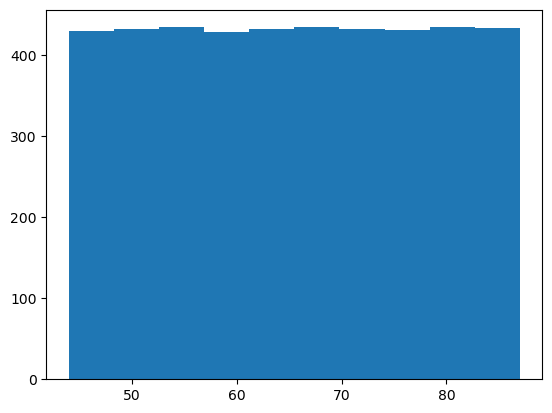

In [28]:
plt.hist(shrub_vcmaxrange)